# Does Spain have an accurate official metric of COVID-19?

## 1. Introduction

Since early 2020, COVID-19 has impacted the whole world way of living, by making people wear facemasks, get vaccinated against it, and so on. Furthermore, **it has killed more than 6 million people** (see updated data [here](https://covid19.who.int/)).

In order to follow the success or failure of the different measures to prevent as many deaths as possible, we need reliable metrics showing the evolution of the pandemic, such as number of cases, hospitalizations, and deaths. However, <ins>the Spanish government stopped following up the total number of COVID-19 cases since March 28, 2022</ins>; and restricted the follow up to people with ages 60 or above. This fact surprised me and I wondered if maybe that metric is more or less representative of the total pandemic evolution in Spain. The final goal of the present project is to answer that question.

To get to that answer with a proper understanding of the pandemic and its evolution, we will be doing other analyses, such as:

1. How is Spanish census like?
2. How has COVID-19 evolved in Spain?
3. How lethal is COVID-19?

The data that we will be using comes from official Spanish data sites:

- The data of Spanish census can be downloaded [here](https://www.ine.es/jaxi/Tabla.htm?path=/t20/e245/p08/l0/&file=01002.px&L=0)
- The data of COVID-19 evolution in Spain can be downloaded [here](https://cnecovid.isciii.es/covid19/#documentaci%C3%B3n-y-datos)
- The data of deaths from patients suffering COVID-19 with complications or comorbilities can be downloaded [here](https://www.ine.es/jaxi/Tabla.htm?path=/t15/p417/covid/&file=01009.px)


### Set the environment and load the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import re
import seaborn as sns
sns.set_theme()

In [2]:
# Read the data in
totals = pd.read_csv("casos_hosp_uci_def_sexo_edad_provres.csv", parse_dates = ["fecha"])
census = pd.read_csv("censo_edades_provincias.csv", sep=";", thousands=".", decimal=",")
comorbility = pd.read_csv("comorbilidad.csv", sep=";", thousands=".", decimal=",")

# Rename census df unnecessary  columns
census.columns = ["province", "age_group", "nationality", "sex", "year", "total"]

# Create a year_month column in totals df to see the evolution by month
totals["year_month"] = totals["fecha"].dt.year.astype(str) + "-" + totals["fecha"].dt.month.astype(str).str.zfill(2)

# Display information about the different tables
display(totals.info())
display(totals.head())

display(census.info())
display(census.head())

display(comorbility.info())
display(comorbility.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1389660 entries, 0 to 1389659
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   provincia_iso  1363440 non-null  object        
 1   sexo           1389660 non-null  object        
 2   grupo_edad     1389660 non-null  object        
 3   fecha          1389660 non-null  datetime64[ns]
 4   num_casos      1389660 non-null  int64         
 5   num_hosp       1389660 non-null  int64         
 6   num_uci        1389660 non-null  int64         
 7   num_def        1389660 non-null  int64         
 8   year_month     1389660 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 95.4+ MB


None

,provincia_iso,sexo,grupo_edad,fecha,num_casos,num_hosp,num_uci,num_def,year_month
0,A,H,0-9,2020-01-01,0,0,0,0,2020-01
1,A,H,10-19,2020-01-01,0,0,0,0,2020-01
2,A,H,20-29,2020-01-01,0,0,0,0,2020-01
3,A,H,30-39,2020-01-01,0,0,0,0,2020-01
4,A,H,40-49,2020-01-01,0,0,0,0,2020-01


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251856 entries, 0 to 251855
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   province     251856 non-null  object
 1   age_group    251856 non-null  object
 2   nationality  251856 non-null  object
 3   sex          251856 non-null  object
 4   year         251856 non-null  int64 
 5   total        251856 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 11.5+ MB


None

,province,age_group,nationality,sex,year,total
0,TOTAL ESPAÑA,TOTAL EDADES,TOTAL,Ambos sexos,2021,47385107
1,TOTAL ESPAÑA,TOTAL EDADES,TOTAL,Ambos sexos,2020,47450795
2,TOTAL ESPAÑA,TOTAL EDADES,TOTAL,Ambos sexos,2019,47026208
3,TOTAL ESPAÑA,TOTAL EDADES,TOTAL,Ambos sexos,2018,46722980
4,TOTAL ESPAÑA,TOTAL EDADES,TOTAL,Ambos sexos,2017,46572132


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 4 columns):
 #   Column                                          Non-Null Count  Dtype 
---  ------                                          --------------  ----- 
 0   Covid-19                                        66 non-null     object
 1   Sexo                                            66 non-null     object
 2   Complicaciones y comorbilidades más frecuentes  66 non-null     object
 3   Total                                           66 non-null     int64 
dtypes: int64(1), object(3)
memory usage: 2.2+ KB


None

,Covid-19,Sexo,Complicaciones y comorbilidades más frecuentes,Total
0,Covid-19 Virus identificado,Total,Total defunciones Covid-19,32652
1,Covid-19 Virus identificado,Total,COMPLICACIONES: Insuficiencia respiratoria,18910
2,Covid-19 Virus identificado,Total,COMPLICACIONES: Neumonía,10950
3,Covid-19 Virus identificado,Total,COMORBILIDAD: Enfermedades hipertensivas,4462
4,Covid-19 Virus identificado,Total,COMORBILIDAD: Demencia,2387


Every graph and result of the present project will be written in English. Still, to help non-Spanish readers understand the tables for the moment, we will list the different variables from each table:

<ins>Dataframe totals</ins>:
- *provincia_iso*: Spanish province
- *sexo*: Sex
- *grupo_edad*: Age group
- *fecha*: Date
- *num_casos*: Number of COVID-19 cases
- *num_hosp*: Number of patients of COVID-19 needing hospitalization
- *num_uci*: Number of patients of COVID-19 needing Intensive Care Unit
- *num_def*: Number of deaths due to COVID-19
- *year_month*: (calculated column) Year and month

<ins>Dataframe census</ins>:
- *province*: Spanish province
- *age_group*: Age group
- *nationality*: Nationality
- *sex*: Sex
- *year*: Year
- *total*: Total number of people within each group

<ins>Dataframe comorbility</ins>:
- *Covid-19*: Confirmed or suspicious of COVID-19
- *Sexo*: Sex
- *Complicaciones y comorbilidades más frecuentes*: COVID-19 complications and common comorbilities
- *Total*: Total number of deaths within each group								
						

## 2. How is Spanish census like? Has it changed since COVID-19?

The Spanish census can be grouped by age group, and therefore we can see how it has evolved in the last years. Furthermore, as we have census data up to 2021, we can see the efects of COVID-19 on Spanish census, as COVID-19 striked in 2020.

### 2.1) Evolution of total census

We need to transform the raw census data for our needs, as it includes numbers for groups and totals, therefore making it difficult to aggregate. Also, original data aggregates data in groups of 5 years (0-4, 5-9, 10-14, etc.), while COVID-19 data aggregates in groups of 10 years (0-9, 10-19, 20-29, etc.).

Let's start by transforming the data for our needs:

In [3]:
# 1. Remove the rows with total values in census df
clean_census = census[
    (census["province"] != "TOTAL ESPAÑA") &
    (census["age_group"] != "TOTAL EDADES") &
    (census["nationality"] != "TOTAL") &
    (census["sex"] != "Ambos sexos")
].copy()

# 2. Clean the age group so it matches the groups in COVID-19 dataframes:

# 2.a) Leave age_group_5 column as "40-44" format
clean_census["age_group"] = clean_census["age_group"].str.replace(r"[a-z\sñá]", "", regex=True)

# 2.b) Map the groups as needed
ages_dict = {
    "0-4": "0-9",
    "5-9": "0-9",
    "10-14": "10-19",
    "15-19": "10-19",
    "20-24": "20-29",
    "25-29": "20-29",
    "30-34": "30-39",
    "35-39": "30-39",
    "40-44": "40-49",
    "45-49": "40-49",
    "50-54": "50-59",
    "55-59": "50-59",
    "60-64": "60-69",
    "65-69": "60-69",
    "70-74": "70-79",
    "75-79": "70-79",
    "80-84": "80+",
    "85-89": "80+",
    "90-94": "80+",
    "95-99": "80+",
    "100": "80+",
}

clean_census = clean_census.replace({"age_group": ages_dict})

# # 3. Transform the total column to integer
# clean_census["total"] = clean_census["total"].str.replace(".", "", regex=False).astype("int64")

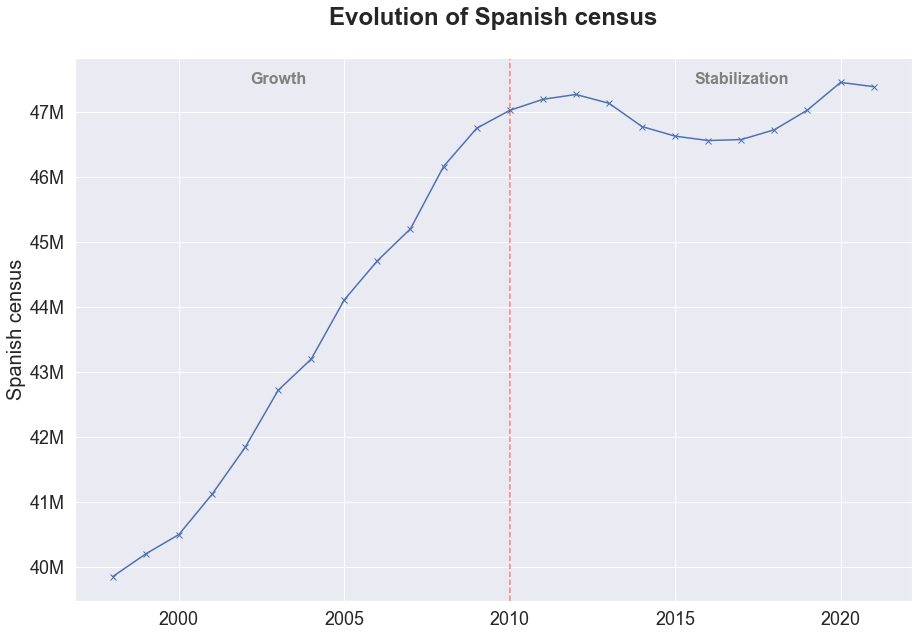

In [4]:
# Create a dataframe aggregating census numbers by year
total_census = clean_census.groupby("year")["total"].agg("sum")
total_census_df = pd.DataFrame(total_census).reset_index()

# Plot the evolution of the census per age group over time
plt.figure(figsize=(15,10))
plt.plot(total_census_df["year"], total_census_df["total"], marker="x")
plt.title("Evolution of Spanish census\n", fontsize="24", fontweight="bold")
plt.xlabel("")
plt.ylabel("Spanish census", fontsize="20")
plt.xticks(fontsize="18")
plt.yticks(ticks=range(40000000, 47500000, 1000000),
           labels=["40M", "41M", "42M", "43M", "44M", "45M", "46M", "47M"], fontsize="18")

plt.axvline(2010, color="red", alpha=.5, ls="--")
plt.text(2003, 47500000, "Growth", horizontalalignment="center", verticalalignment="center",
         color="grey", fontsize="16", fontweight="bold")
plt.text(2017, 47500000, "Stabilization", horizontalalignment="center", verticalalignment="center",
         color="grey", fontsize="16", fontweight="bold")

plt.show()

The graph show that, after an increasing tendency in Spanish census, <ins>the numbers have stabilized around **47M**</ins>. Therefore we will use 2010 as the reference year to separate growth from stable numbers.

### 2.2) Evolution of census by age group

While the total Spanish census has more or less stabilized since 2010 around 47 million people, the distribution between age groups might be evolving. We'll answer this question below:

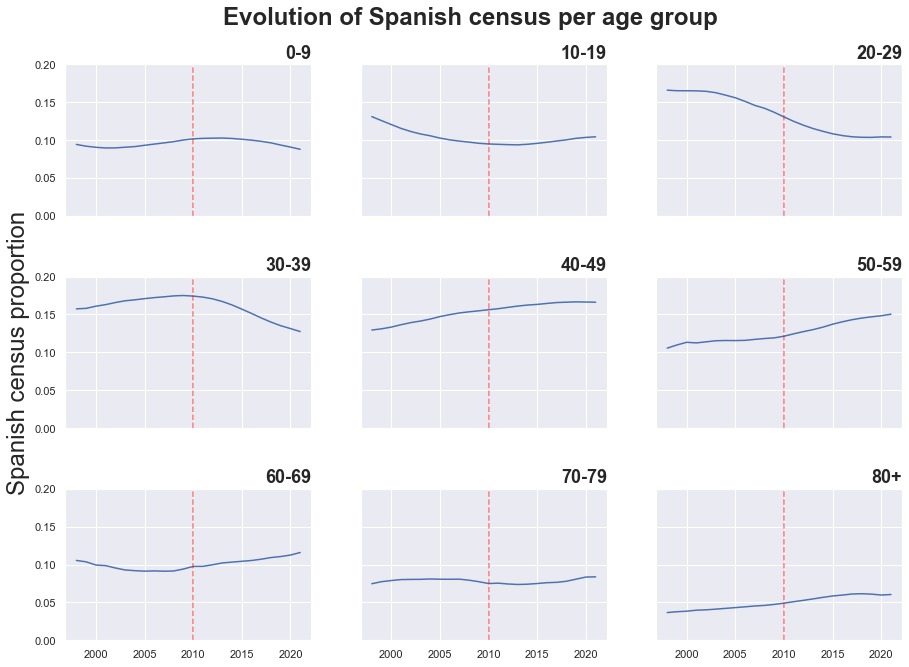

In [5]:
# Add a column age_group_prop displaying the proportion of each age group and year
clean_census["age_group_prop"] = clean_census["total"] / clean_census.groupby("year")["total"].transform("sum")

# Create a dataframe aggregating total numbers and proportions by year and age group
age_census = clean_census.groupby(["year", "age_group"])[["total", "age_group_prop"]].agg("sum")
age_census_df = pd.DataFrame(age_census).reset_index()

# Plot the evolution of the census per age group over time
fig, ax = plt.subplots(3, 3, figsize=(15,10))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=.2, hspace=.4)

for i, age_group in zip(range(1,10), age_census_df["age_group"].unique()):
    subdf = age_census_df[age_census_df["age_group"] == age_group]
    plt.subplot(3, 3, i)
    plt.ylim(0, .2)
    plt.plot(subdf["year"], subdf["age_group_prop"])
    plt.title(age_group, fontsize="18", fontweight="bold", loc="right")
    plt.axvline(2010, color="red", alpha=.5, ls="--")
    # Include y-axis title in left plots
    if i == 4:
        plt.ylabel("Spanish census proportion", fontsize="24")
    # Remove x-ticks except bottom plots
    if i <= 6:
        plt.xticks(ticks=range(2000, 2021, 5), labels=[])
    # Remove y-ticks except left plots
    if i not in [1, 4, 7]:
        plt.yticks(ticks=np.arange(.0, .21, .05), labels=[])    

fig.suptitle("Evolution of Spanish census per age group", fontsize="24", fontweight="bold")
plt.show()

The plots above show that, since 2010:
1. Age groups 0-9, 20-29 and 30-39 have diminished their numbers.
2. Age group 10-19 has stabilized, with a slight increasing tendency.
3. Age groups 40-49 and above have clearly increased.

Therefore, we can confirm that the Spanish population is becoming older with time.

Besides, when looking at possible COVID-19 effects in Spanish census, <ins>we don't see any clear pattern of diminishing numbers in any group age when comparing 2020 with 2021</ins>.


## 3. How has COVID-19 affected Spain?

### 3.1) Evolution of number of cases and severity

We will start by looking at how the number of COVID-19 cases has evolved in Spain. Furthermore, in order to understand the severity of the pandemic, we will look at the proportion of COVID-19 patients that needed hospitalization and intensive care (ICU), plus the proportion of patients that died.

A modification is to be made in the data of hospitalizations, ICU and deaths from January - February 2020, as the data shows more of these cases than total COVID-19 cases:

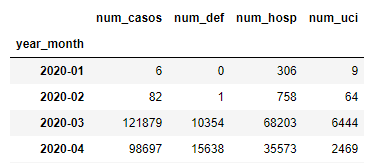

Therefore, we will set these values to zero to avoid data misleading.

Starting dates of COVID-19 variants have been chosen following [World Health Organization data](https://www.who.int/es/activities/tracking-SARS-CoV-2-variants).

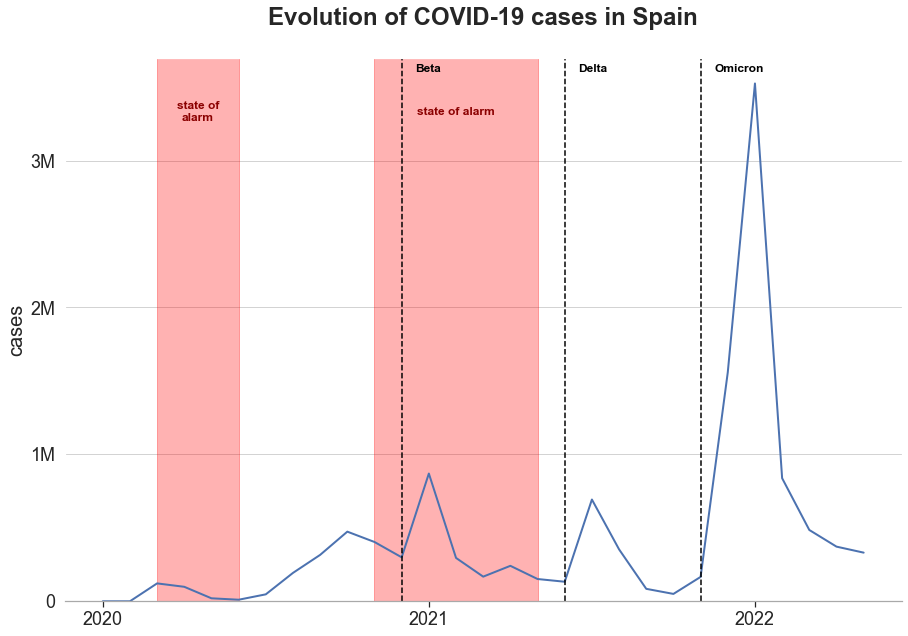

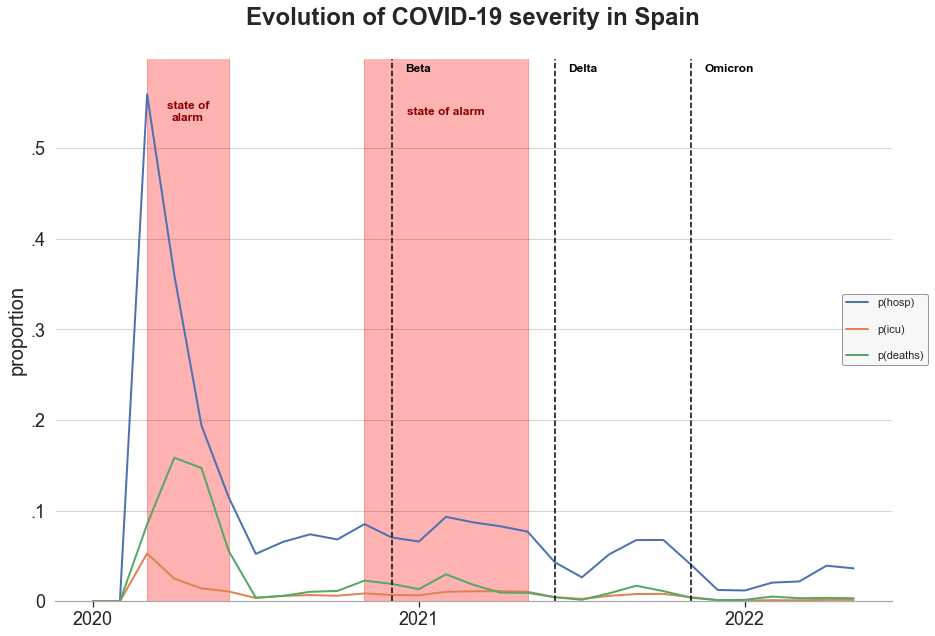

In [6]:
# Create a pivot table to aggregate number of COVID-19 cases, hospitalizations, ICU and deaths across year_month
evolution_df = totals[totals["grupo_edad"] != "NC"].pivot_table(index="year_month",
                                                                values=["num_casos", "num_hosp", "num_uci", "num_def"],
                                                                aggfunc="sum")

# Set hospitalizations, ICU cases and deaths to zero in January - February 2020
evolution_df.loc["2020-01":"2020-02", "num_def":"num_uci"] = 0

# Calculate columns with proportions of hospitalizations, ICU and deaths
evolution_df["p(hosp)"] = evolution_df["num_hosp"] / evolution_df["num_casos"]
evolution_df["p(icu)"] = evolution_df["num_uci"] / evolution_df["num_casos"]
evolution_df["p(deaths)"] = evolution_df["num_def"] / evolution_df["num_casos"]

# Prepare the lists to loop over to create the pivot dataframes and plots
graphs = ["num_casos", ["p(hosp)", "p(icu)", "p(deaths)"]]
metric_names = ["cases", "proportion"]
max_y_vals = [3700000, .6]
y_steps = [1000000, .1]
y_labels = [["0", "1M", "2M", "3M"], ["0", ".1", ".2", ".3", ".4", ".5"]]
titles = ["Evolution of COVID-19 cases in Spain", "Evolution of COVID-19 severity in Spain"]

# Set x axis on the bottom
plt.rcParams["xtick.labeltop"] = plt.rcParams["xtick.top"] = False
plt.rcParams["xtick.bottom"] = plt.rcParams["xtick.labelbottom"] = True

# Iterate over the lists above to create the necessary plots
for graph, metric_name, max_y_val, y_step, y_label, title in zip(graphs, metric_names, max_y_vals, y_steps, y_labels, titles):
    ax = evolution_df[graph].plot(figsize=(15,10), linewidth=2)
    
    # State of alarm areas and texts
    plt.axvspan(2, 5, alpha=0.3, color="red")
    plt.text(3.5, .9*max_y_val, "state of\nalarm", color="darkred",
             horizontalalignment="center", verticalalignment="center", fontweight="bold")
    plt.axvspan(10, 16, alpha=0.3, color="red")
    plt.text(13, .9*max_y_val, "state of alarm", color="darkred",
             horizontalalignment="center", verticalalignment="center", fontweight="bold")

    # COVID-19 variants lines and names
    plt.axvline(11, color="black", ls="--")
    plt.text(11.5, .98*max_y_val, "Beta", color="black",
             horizontalalignment="left", verticalalignment="center", fontweight="bold")
    plt.axvline(17, color="black", ls="--")
    plt.text(17.5, .98*max_y_val, "Delta", color="black",
             horizontalalignment="left", verticalalignment="center", fontweight="bold")
    plt.axvline(22, color="black", ls="--")
    plt.text(22.5, .98*max_y_val, "Omicron", color="black",
             horizontalalignment="left", verticalalignment="center", fontweight="bold")
    
    # Set the rest of parameters: labels, title, legend...
    plt.xlabel("")
    plt.ylabel(metric_name, fontsize="20")
    plt.title(title + "\n", fontsize="24", fontweight="bold")
    plt.grid(axis="y", visible=True, which="major", color="lightgray")
    ax.tick_params(bottom=True)
    plt.xticks(ticks=range(0,30,12), labels=["2020", "2021", "2022"], fontsize="18")
    plt.yticks(ticks=np.arange(0, max_y_val, y_step), labels=y_label, fontsize="18")
    if graph == ["p(hosp)", "p(icu)", "p(deaths)"]:
        plt.legend(loc="center right", facecolor="whitesmoke", edgecolor="gray", bbox_to_anchor=(1.05, .5), labelspacing=1.5)
    ax.set_facecolor("white")
    ax.spines["bottom"].set_visible(True)
    ax.spines["bottom"].set_color("darkgrey")
    plt.ylim(0, max_y_val)

    # Display the graph
    plt.show()

The graph above shows that, <ins>while the number of COVID-19 cases has increased since the first wave</ins> (March - June 2020), specially with the Omicron variant, <ins>the proportion of patients that need hospitalization or Intensive Care, or die, has been decreasing since then</ins>.


### 3.2) How lethal is COVID-19 depending on comorbilities and complications?

To better understand the severity of COVID-19, we will take a look at how many people were killed by COVID-19 in 2020 (the year with the highest death rate) depending on: 1) whether COVID-19 caused additional complications, 2) whether they had other diseases (comorbility).

In [7]:
# Keep rows with confirmed COVID-19 so our conclusions are backed with reliable data,
# Remove the rows that aggregate men and women, so we can inspect whether there are differences between genders
comorbility_clean = comorbility[(comorbility["Covid-19"] == "Covid-19 Virus identificado") & (comorbility["Sexo"] != "Total")]

# Reset index and drop column with previous index
comorbility_clean = comorbility_clean.reset_index().drop(["index"], axis=1)

display(comorbility_clean)

,Covid-19,Sexo,Complicaciones y comorbilidades más frecuentes,Total
0,Covid-19 Virus identificado,Hombres,Total defunciones Covid-19,17688
1,Covid-19 Virus identificado,Hombres,COMPLICACIONES: Insuficiencia respiratoria,10424
2,Covid-19 Virus identificado,Hombres,COMPLICACIONES: Neumonía,6348
3,Covid-19 Virus identificado,Hombres,COMORBILIDAD: Enfermedades hipertensivas,2116
4,Covid-19 Virus identificado,Hombres,COMORBILIDAD: Demencia,935
5,Covid-19 Virus identificado,Hombres,COMORBILIDAD: Insuficiencia renal,1634
6,Covid-19 Virus identificado,Hombres,COMORBILIDAD: Diabetes mellitus,1296
7,Covid-19 Virus identificado,Hombres,COMORBILIDAD: Enfermedad de Alzheimer,450
8,Covid-19 Virus identificado,Hombres,COMORBILIDAD: Insuficiencia cardíaca,623
9,Covid-19 Virus identificado,Hombres,COMORBILIDAD: Enfermedades crónicas de las vía...,1046


The table above needes some cleaning before we can plot the data:
1. The rows with the total deaths caused by COVID-19, "Total defunciones Covid-19" are summing deaths without any complication, plus deaths with complications, that already have their rows: "COMPLICACIONES: Insuficiencia respiratoria" and "COMPLICACIONES: Neumonía", therefore it will be more useful for plotting purposes to change these total rows for rows showing the deaths without any other complication.
2. We can separate complications from comorbility in different columns, and clean their labels so the plots will be easier to read.
3. Update the new labels to English.

In [8]:
# 1. Change the row with the total COVID-19 deaths for men and women with the values for deaths without any complication
comorbility_clean.iloc[0, 2:4] = ["COMPLICACIONES: None", 17688-(10424+6348)]
comorbility_clean.iloc[11, 2:4] = ["COMPLICACIONES: None", 14964-(8486+4602)]

# 2. Separate complications from comorbility and clean labels
comorbility_clean["Complication"] = comorbility_clean["Complicaciones y comorbilidades más frecuentes"].str.extract(r"COMPLICACIONES: (\w.+)")
comorbility_clean["Comorbility"] = comorbility_clean["Complicaciones y comorbilidades más frecuentes"].str.extract(r"COMORBILIDAD: (\w.+)")

# 3. Translate new labels to English
sex_dict = {
    'Hombres': "Men",
    'Mujeres': "Women"
}

complications_dict = {
    'Insuficiencia respiratoria': "Respiratory Insufficiency",
    'Neumonía': "Pneumonia"
}

comorbility_dict = {
    'Enfermedades hipertensivas': "Hypertensive diseases",
    'Demencia': "Dementia",
    'Insuficiencia renal': "Renal insufficiency",
    'Diabetes mellitus': "Diabetes",
    'Enfermedad de Alzheimer': "Alzheimer",
    'Insuficiencia cardíaca': "Heart failure",
    'Enfermedades crónicas de las vías respiratorias inferiores (excepto asma)': "C. dis. of lower resp. tract (not asthma)",
    'Enfermedades cerebrovasculares': "Cerebrovascular diseases"
}

comorbility_clean.replace({
    "Complication":complications_dict,
    "Comorbility":comorbility_dict,
    "Sexo":sex_dict},
    inplace=True)

display(comorbility_clean)

,Covid-19,Sexo,Complicaciones y comorbilidades más frecuentes,Total,Complication,Comorbility
0,Covid-19 Virus identificado,Men,COMPLICACIONES: None,916,None,NaN
1,Covid-19 Virus identificado,Men,COMPLICACIONES: Insuficiencia respiratoria,10424,Respiratory Insufficiency,NaN
2,Covid-19 Virus identificado,Men,COMPLICACIONES: Neumonía,6348,Pneumonia,NaN
3,Covid-19 Virus identificado,Men,COMORBILIDAD: Enfermedades hipertensivas,2116,NaN,Hypertensive diseases
4,Covid-19 Virus identificado,Men,COMORBILIDAD: Demencia,935,NaN,Dementia
5,Covid-19 Virus identificado,Men,COMORBILIDAD: Insuficiencia renal,1634,NaN,Renal insufficiency
6,Covid-19 Virus identificado,Men,COMORBILIDAD: Diabetes mellitus,1296,NaN,Diabetes
7,Covid-19 Virus identificado,Men,COMORBILIDAD: Enfermedad de Alzheimer,450,NaN,Alzheimer
8,Covid-19 Virus identificado,Men,COMORBILIDAD: Insuficiencia cardíaca,623,NaN,Heart failure
9,Covid-19 Virus identificado,Men,COMORBILIDAD: Enfermedades crónicas de las vía...,1046,NaN,C. dis. of lower resp. tract (not asthma)


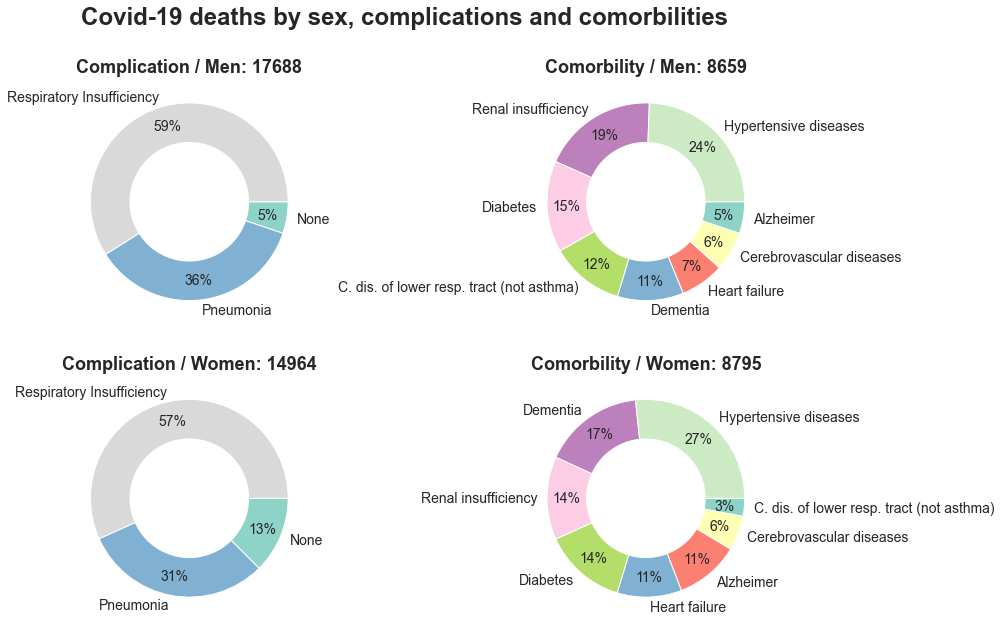

In [9]:
# Initiate i value for grid plot and the general figure
i = 1
plt.figure(figsize=(15,10))

# Iterate over the necessary values to create the plots
for sex in ["Men", "Women"]:
    
    for column in ["Complication", "Comorbility"]:
        
        plt.subplot(2, 2, i)
        
        # Use adequate filtering for each analysis
        if column == "Complication":
                data = comorbility_clean[(comorbility_clean["Sexo"] == sex) &
                                         (comorbility_clean.Complication.notna())].sort_values(by="Total", ascending=True)
        elif column == "Comorbility":
                data = comorbility_clean[(comorbility_clean["Sexo"] == sex) &
                                         (comorbility_clean.Comorbility.notna())].sort_values(by="Total", ascending=True)
        
        # Set plot colors theme
        theme = plt.get_cmap("Set3")
        colors = [theme(1. * i / len(data)) for i in range(len(data))]
        
        # Calculate subtotal and create a title with the number
        subtotal_deaths = data["Total"].sum()
        plt.title(column + " / " + sex + ": " + str(subtotal_deaths), fontsize=18, fontweight="bold")
        
        # Generate subplot and increment i value for next plot
        plt.pie(data["Total"], labels=data[column], textprops={'fontsize': 14}, autopct='%1.0f%%', pctdistance=0.8,
                colors=colors, startangle=0, counterclock=False)
        i += 1
        
        # Draw white circle for a donut-shape
        centre_circle = plt.Circle((0,0),0.60,fc='white')
        fig = plt.gcf()
        fig.gca().add_artist(centre_circle)

# General title and show the plots
plt.suptitle("Covid-19 deaths by sex, complications and comorbilities", fontsize="24", fontweight="bold")
plt.show()

From the graphs above we can conclude that, <ins>in 2020</ins>:
- There were around twice as much deaths caused by COVID-19 and derivated complications compared with COVID-19 plus other comorbility.
- <ins>More than half of total deaths in COVID-19 patients (without comorbilities) were aggravated by respiratory insufficiency</ins>.
- While hypertensive diseases was the most common comorbility for men and women, there were noteworthy sex diffences in the following comorbilities:
    - Renal insufficiency (**19%** men - **14 %** women)
    - Dementia (**11%** men - **17%** women)
    - And specially, chronic diseases of lower respiratory tract excluding asthma (**12%** men - **3%** women)
- <ins>Only **5%** and **13%** deaths were caused by COVID-19 without any additional complication</ins> in men and women, respectively.


### 3.3) Evolution of number of cases, hospitalizations and deaths across age groups

In the following analysis, we will inspect whether the evolution of COVID-19 differs across age groups.

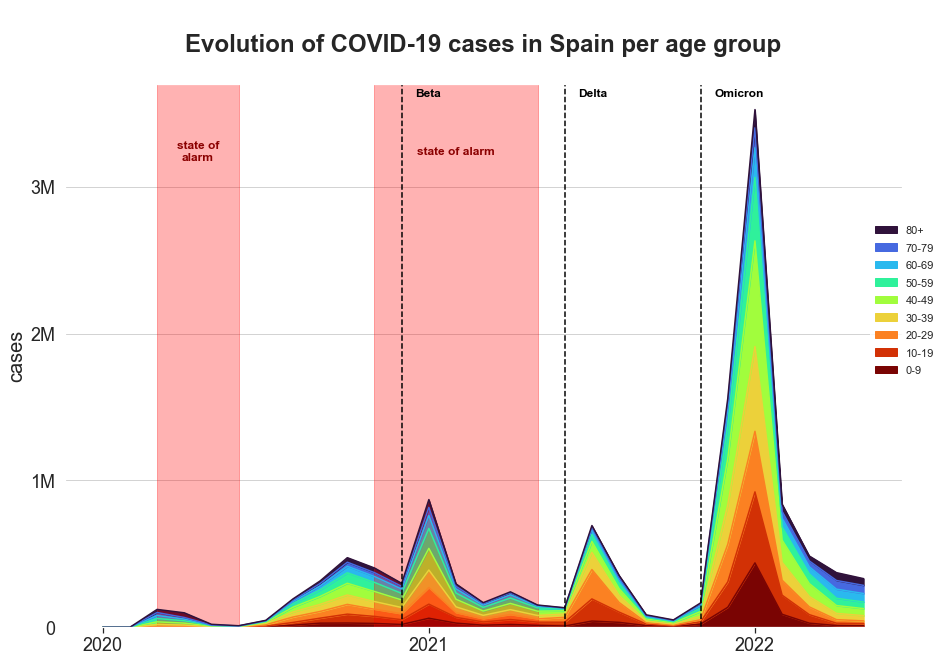

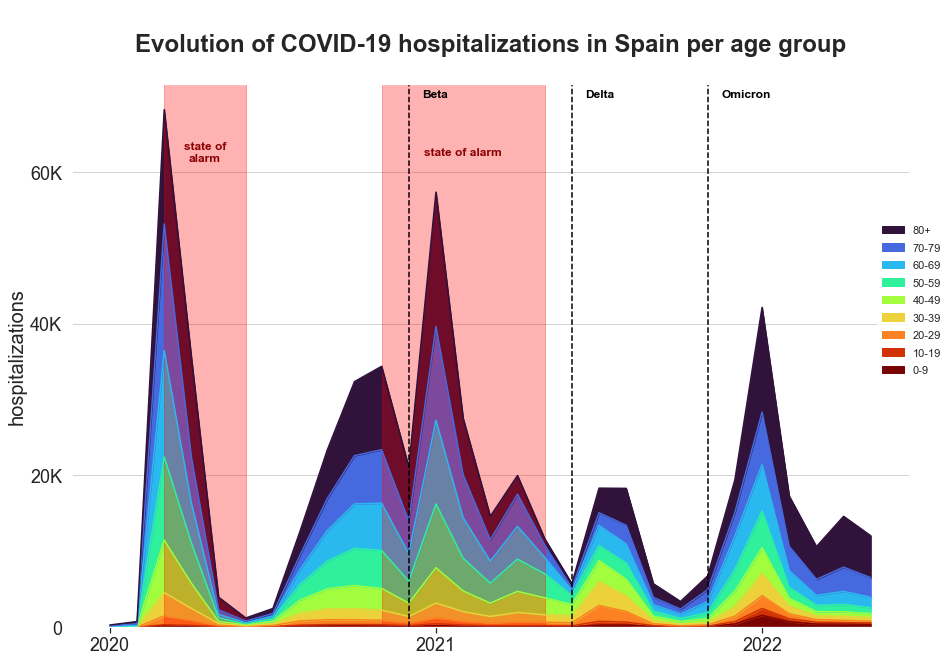

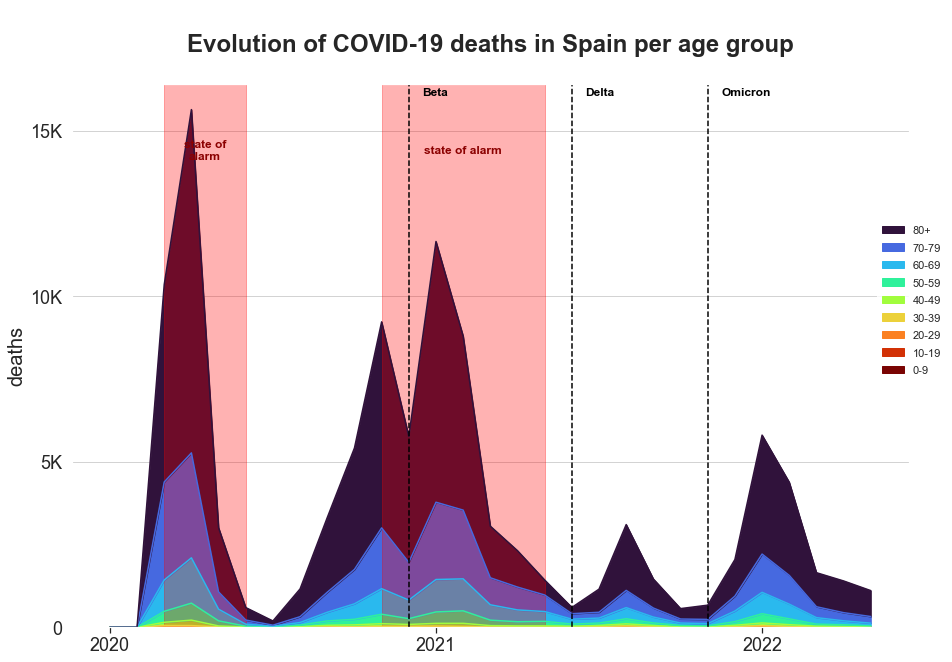

In [10]:
# Initiate an empty dictionary to store the resulting dataframes
pivot_dfs = {}

# Prepare the lists to loop over to create the pivot dataframes and plots
metrics = ["num_casos", "num_hosp", "num_def"]
metric_names = ["cases", "hospitalizations", "deaths"]
max_y_vals = [3600000, 69500, 16000]
y_steps = [1000000, 20000, 5000]
y_labels=[["0", "1M", "2M", "3M"], ["0", "20K", "40K", "60K"], ["0", "5K", "10K", "15K"]]

# Iterate over the lists above to create the necessary plots
for metric, metric_name, max_y_val, y_step, y_labels in zip(metrics, metric_names, max_y_vals, y_steps, y_labels):

    # Create a pivot table to aggregate number of COVID-19 cases across age group and year_month
    pivot_dfs[metric] = totals[totals["grupo_edad"] != "NC"].pivot_table(index="year_month", columns="grupo_edad",
                                                                    values=metric, aggfunc="sum")
    # Plot the evolution per age group
    ax = pivot_dfs[metric].plot(kind="area", stacked=True, figsize=(15,10), colormap="turbo_r")

    # State of alarm areas and texts
    plt.axvspan(2, 5, alpha=0.3, color="red")
    plt.text(3.5, .9*max_y_val, "state of\nalarm", color="darkred",
             horizontalalignment="center", verticalalignment="center", fontweight="bold")
    plt.axvspan(10, 16, alpha=0.3, color="red")
    plt.text(13, .9*max_y_val, "state of alarm", color="darkred",
             horizontalalignment="center", verticalalignment="center", fontweight="bold")

    # COVID-19 variants lines and names
    plt.axvline(11, color="black", ls="--")
    plt.text(11.5, 1.01*max_y_val, "Beta", color="black",
             horizontalalignment="left", verticalalignment="center", fontweight="bold")
    plt.axvline(17, color="black", ls="--")
    plt.text(17.5, 1.01*max_y_val, "Delta", color="black",
             horizontalalignment="left", verticalalignment="center", fontweight="bold")
    plt.axvline(22, color="black", ls="--")
    plt.text(22.5, 1.01*max_y_val, "Omicron", color="black",
             horizontalalignment="left", verticalalignment="center", fontweight="bold")

    # Set the rest of parameters: labels, title, legend...
    ax.set_facecolor("white")
    plt.xlabel("")
    plt.ylabel(metric_name, fontsize="20")
    plt.title("\nEvolution of COVID-19 " + metric_name + " in Spain per age group\n", fontsize="24", fontweight="bold")
    plt.grid(axis="y", visible=True, which="major", color="lightgray")
    ax.tick_params(bottom=True)
    plt.xticks(ticks=range(0,30,12), labels=["2020", "2021", "2022"], fontsize="18")
    plt.yticks(ticks=range(0, max_y_val, y_step), labels=y_labels , fontsize="18")
    plt.legend(loc="upper right", bbox_to_anchor=(1.05, .5), labelspacing=-2.5, facecolor="white", edgecolor="white")

    # Display the graph
    plt.show()

From the graphs above we can draw the following conclusions:

1. The first wave (March - June 2020), although having the lowest number of cases (**March, 2020: 120K cases**), caused the highest number of hospitalizations (**March, 2020: 68K hospitalizations**) and deaths (**April, 2020: 16K deaths**).
2. <ins>The states of alarm served their purpose</ins> of lowering the numbers of COVID-19 cases, hospitalizations and deaths.
3. <ins>The number of cases have increased across time</ins>, with a massive rise since the appearance of Omicron (**January, 2022: 3.5M cases**).
4. Even if the number of cases have increased across time, <ins>the number of hospitalizations and deaths have been decreasing</ins>. While in March, 2020 there were 68K hospitalizations and 10K deaths, in January, 2022, with the highest number of COVID-19 cases ever, there were 42K hospitalizations and 6K deaths.
5. <ins>Younger people are increasing their share of the total number of COVID-19 cases over time</ins>: while people with ages 60 or more comprised **50%** of COVID-19 cases in the first wave, this number decreased to only **13%** of COVID-19 cases in January, 2022.
6. Still, <ins>the relative number of hospitalizations and deaths remain constant over time for people older than 60</ins>: they suffer 62% of the hospitalizations and 93% of deaths regardless of the period.


### 3.4) Evolution of the proportion of COVID-19 cases in census per age group

On the following analysis, we will compare the number of COVID-19 cases, hospitalizations and deaths, across age groups with those age groups in Spanish census, to answer the following question:

*What proportion of each census age group is having COVID, and how do they evolve across time?*

In [11]:
# Create a pivot table having the census in years 2020 and above
pivot_census = age_census_df[age_census_df["year"] >= 2020].pivot_table(index="year", columns="age_group", values="total")
display("Census per age group and year:", pivot_census.head())

# Define a function that returns the proportion of people per age group that had COVID-19 per age group and month and year
def perc_cases(row):
    """
    Takes a row with the data of COVID-19 cases per column (age group) and returns a row with the proportion of those cases,
    taking into account the census dataframe. This is, it divides the COVID-19 cases per age group and year_month by the
    census of that age group on that year.
    
    Args:
        row: The row to be transformed
    
    Returns:
        proportions_row: The row once the transformations have been computed
    """
    proportions_row = []
    year = int(row.name[:4])
    if year in (2020, 2021):
        for age_group in row.index:
            datum = row[age_group]
            reference_census = pivot_census.loc[year, age_group]
            proportion_affected = round(datum / reference_census, 5)
            proportions_row.append(proportion_affected)
        return proportions_row
    
# Apply the function to the previous pivot dataframes to get the proportions

## Initiate an empty dictionary to store the resulting dataframes
prop_dfs ={}

## Use the same list as in previous step to iterate over relevant metrics
metrics = ["num_casos", "num_hosp", "num_def"]

for metric in metrics:
    prop_dfs[metric] =  pivot_dfs[metric].apply(perc_cases, axis=1, result_type="expand")
    prop_dfs[metric].columns = pivot_dfs[metric].columns

'Census per age group and year:'

age_group,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80+
year,,,,,,,,,
2020,4307135,4912519,4944640,6230403,7891737,7033306,5336986,3960045,2834024
2021,4163467,4944058,4931184,6036852,7869552,7121930,5488108,3967139,2862817


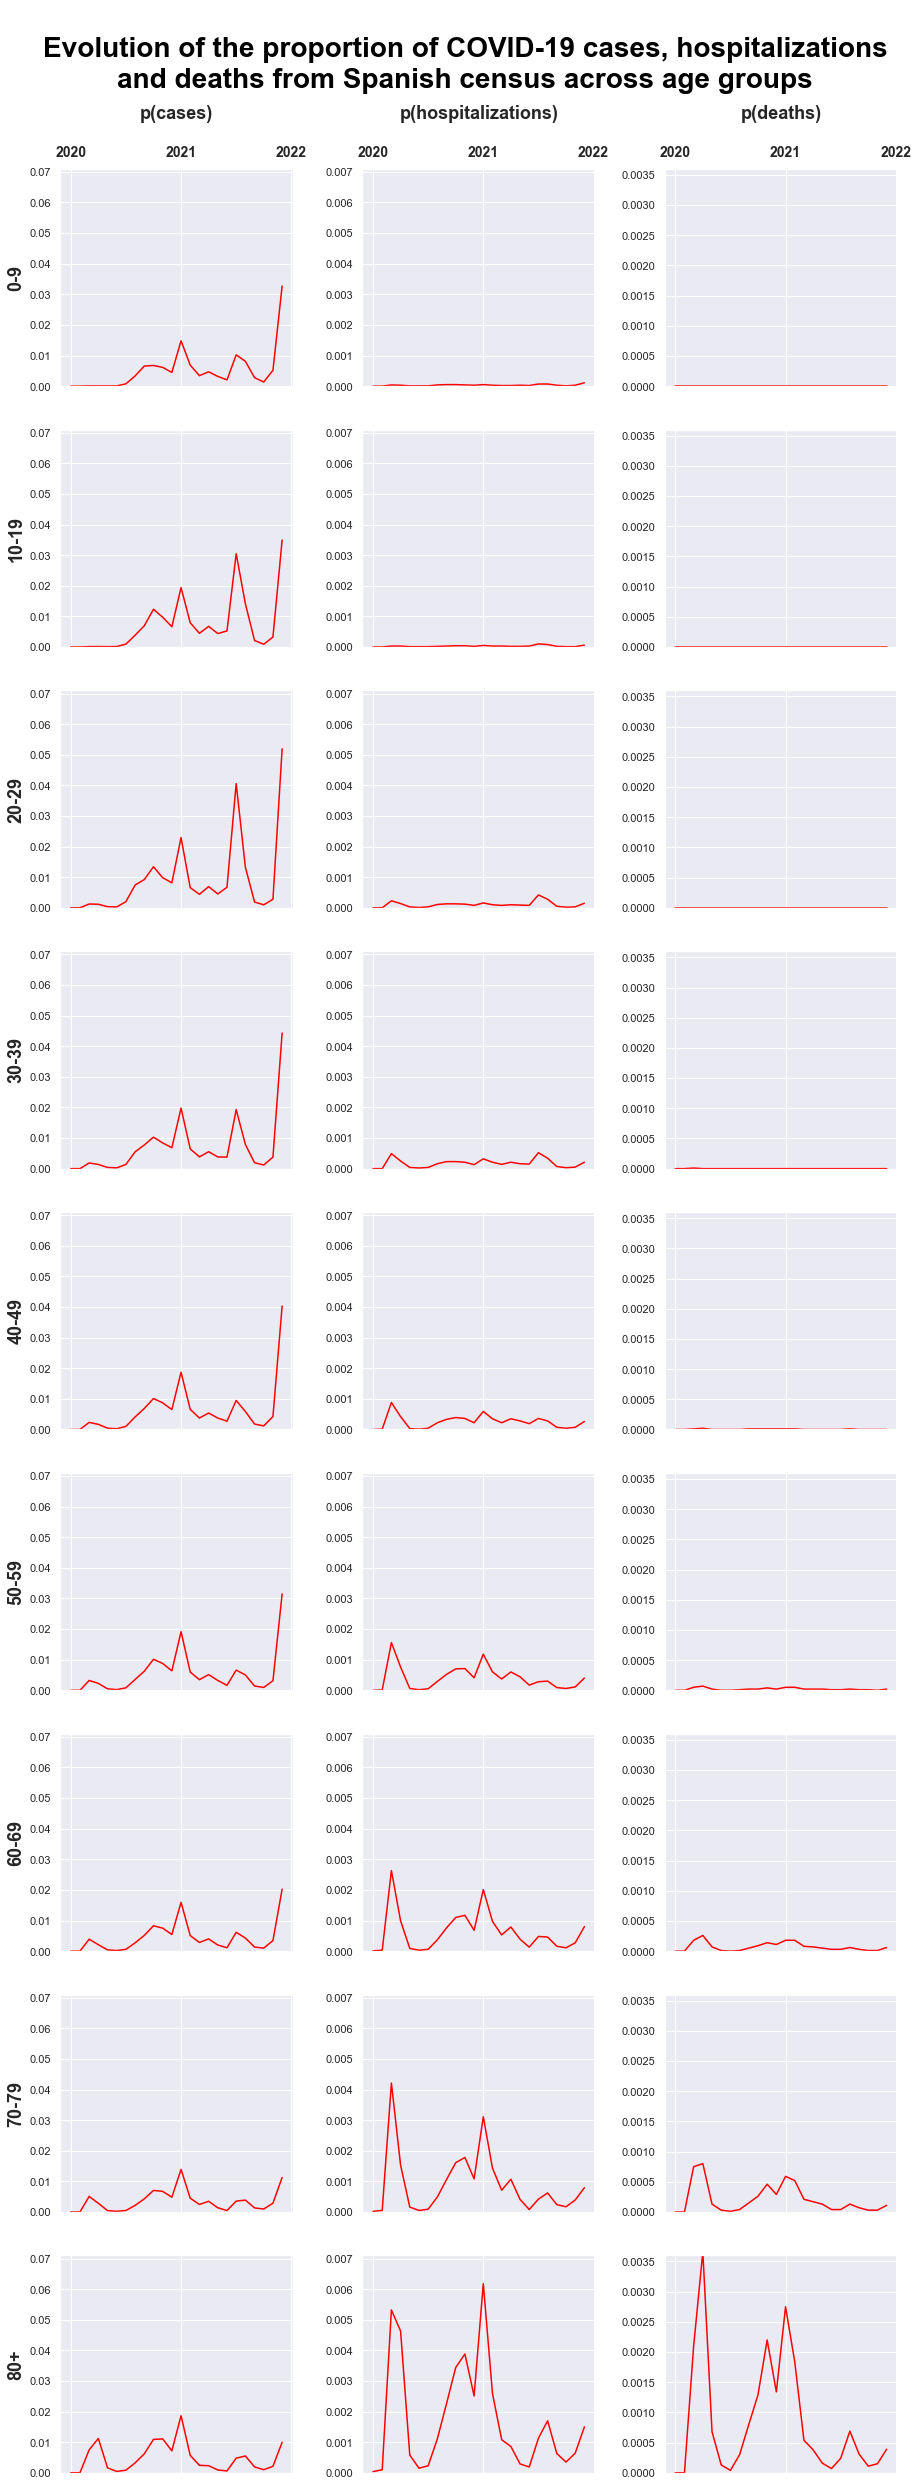

In [12]:
# Set size and general parameters for plots
plt.figure(figsize=(15, 40))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=.3, hspace=.2)
plt.rcParams["xtick.labeltop"] = True
plt.rcParams["xtick.top"] = False
plt.rcParams["xtick.bottom"] = plt.rcParams["xtick.labelbottom"] = False

# Create lists to loop over the subplots
metrics = ["num_casos", "num_hosp", "num_def"]
max_y_vals = [.071, .0071, .0036]
y_steps = [.01, .001, .0005]

# Iterate over the lists above to create the necessary plots
for column, metric, max_y_val, y_step in zip([1, 2, 3], metrics, max_y_vals, y_steps):
    
    # Iterate over age groups and proper numbers to display each age group metric in the same row
    for age_group, i in zip(prop_dfs[metric].columns, range(column, 28, 3)):
        
        # Plot the evolution of the proportion of COVID-19 cases for each age groups
        plt.subplot(9, 3, i)
        prop_dfs[metric].loc[:, age_group].plot(kind='line', color="red")

        # Set axis parameters
        plt.ylim(0, max_y_val)
        plt.yticks(ticks=np.arange(0, max_y_val, y_step))
        plt.xlabel("")
        plt.xticks([0, 12, 24], labels=[2020, 2021, 2022], fontsize="14", fontweight="bold")
                     
        # Set specific subplot parameters so only some of them show titles or labels
        if i == 1:
            plt.title("p(cases)\n", fontsize="18", fontweight="bold")
        if i == 2:
            plt.title("p(hospitalizations)\n", fontsize="18", fontweight="bold")
            plt.text(10, .01, "\nEvolution of the proportion of COVID-19 cases, hospitalizations\nand deaths from Spanish census across age groups\n\n",
                     color="black", horizontalalignment="center", verticalalignment="center", fontsize="28", fontweight="bold")
        if i == 3:
            plt.title("p(deaths)\n", fontsize="18", fontweight="bold")
        if i in range(1, 28, 3):
            plt.ylabel(age_group, fontsize="18", fontweight="bold")
        if i >= 4:
            plt.xticks([0, 12, 24], labels=[])

# Display the plots
plt.show()

From the graph above, we can conclude:

- Especially since Omicron, <ins>there is an negative relationship between age and proportion of census catching COVID-19 across time</ins>: more younger people are having COVID-19, while the proportion of older people catching COVID-19 remains more or less constant.
- The proportion of patients that need hospitalization or die because of COVID-19 is diminishing across time for all age groups.


## 4. Conclusion: Is it accurate to restrict follow up to people with ages 60 or above?

<ins>Although the number of COVID-19 cases are increasing since the Omicron variant, they are decreasing for older people</ins> both relative to the total number of cases and relative to Spanish census. **Therefore, restricting follow up of COVID-19 to people with ages of 60** or more might be very convenient for the government (i.e., they can show that the numbers are getting better, "especially" for the riskier, older people), but **does not represent reality**.